## Reconocimiento de comando de voz

Compara modelos basados en redes recurrentes y convolucionales para el reconocimiento de
comandos de voz usando el conjunto Speech Commands. En particular, deberás:

- Entrenar un modelo basado en redes recurrentes.
- Entrenar un modelo basado en capas convolucionales 1D.
- Entrenar un modelo basado en capas convolucionales 2D.
- Graficar las pérdidas por época en los conjuntos de entrenamiento y validación.
- Evaluar los modelos usando métricas apropiadas para la tarea y sus características (por ej. si hay desbalance entre clases).
- Discutir los resultados.

En todos los casos, se deberán representar los comandos de voz mediante espectogramas Mel, Mel-Log o MFCCs.

### 1. Preparación

In [1]:
import random 

# audio
import librosa
import IPython as ip

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch as th
import torch.nn as nn

# redes audio
import torchaudio
import torchaudio.transforms as T

# redes neuronales
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS

# barras de progreso
from tqdm.auto import trange, tqdm

#Counter
import collections

print(th.__version__)
print(torchaudio.__version__)
print(librosa.__version__)

2.7.0+cu126
2.7.0+cu126
0.11.0


### 2. Datos

In [2]:
DATA_DIR = 'datos'

# Se utiliza el conjunto de datos SPEECHCOMMANDS:
# https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html#torchaudio.datasets.SPEECHCOMMANDS
ds = SPEECHCOMMANDS(DATA_DIR, download=True)
ds

### 3. Exploración

In [3]:
waveform, sample_rate, label, id_spk, utt = ds[3078]

print(
  f'Etiqueta: {label}\n'
  f'Forma de onda: {waveform.shape}\n'
  f'Frecuencia de muestreo: {sample_rate}\n'
  f'Duración: {waveform.shape[1] / sample_rate}\n'
  f'Tipo: {waveform.dtype}\n'
)

Etiqueta: bed
Forma de onda: torch.Size([1, 14861])
Frecuencia de muestreo: 16000
Duración: 0.9288125
Tipo: torch.float32



In [4]:
waveform

tensor([[ 0.0002,  0.0004,  0.0002,  ..., -0.0002, -0.0003, -0.0003]])

In [5]:
durations = []
for i in trange(len(ds)):
  waveform, sample_rate, label ,id_spk, utt = ds[i]
  num_channels, samples = waveform.shape
  durations.append(samples)

  0%|          | 0/105829 [00:00<?, ?it/s]

Duraciones
Counter({16000: 95394, 14336: 696, 15702: 649, 15604: 575, 15019: 575, 14861: 551, 14118: 503, 12288: 490, 13375: 455, 13654: 415, 12971: 381, 12056: 370, 10240: 295, 12632: 247, 13653: 239, 12970: 237, 11606: 235, 11605: 210, 15018: 208, 11889: 200, 15701: 198, 10922: 195, 10923: 170, 9557: 156, 11146: 144, 8192: 138, 8874: 136, 11888: 135, 12631: 127, 12136: 121, 11145: 107, 10402: 99, 12052: 86, 9558: 80, 10403: 77, 9659: 76, 8875: 69, 7509: 67, 9660: 57, 6826: 48, 8916: 45, 12132: 41, 6144: 33, 8173: 32, 8917: 31, 7430: 22, 15360: 18, 6687: 15, 8174: 15, 11976: 15, 12456: 13, 13995: 12, 13312: 12, 11947: 11, 5461: 11, 15531: 10, 7431: 10, 14678: 10, 12630: 9, 12212: 9, 12376: 9, 12800: 8, 9216: 7, 15872: 7, 14507: 7, 11776: 7, 14848: 7, 5201: 6, 13142: 6, 9899: 6, 12459: 6, 13141: 6, 12216: 6, 13483: 5, 11264: 5, 7510: 5, 12118: 5, 12536: 5, 5944: 5, 14677: 5, 6827: 5, 10581: 4, 12629: 4, 9046: 4, 4778: 4, 9387: 4, 15190: 4, 7168: 3, 15189: 3, 14490: 3, 7851: 3, 14166: 3

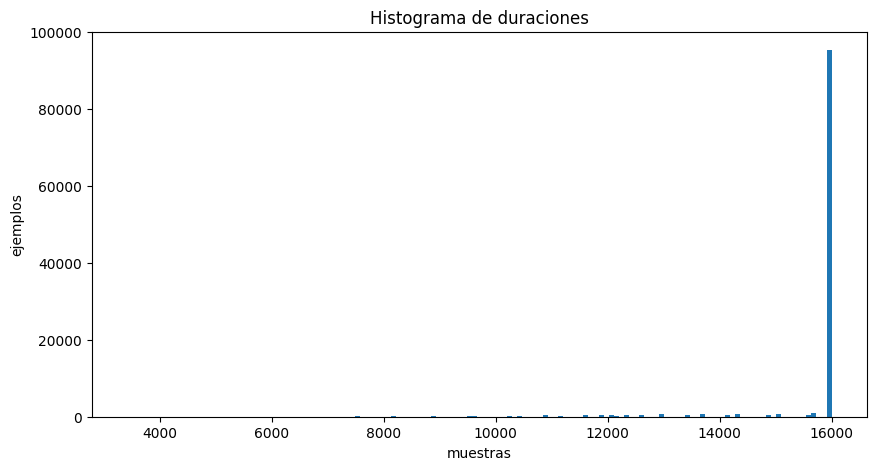

In [6]:
counter = collections.Counter(durations)

print('Duraciones')
print(counter)

plt.figure(figsize=(10, 5))
plt.hist(durations, bins=len(counter.keys())+1)
plt.bar(counter.keys(), counter.values())
plt.title('Histograma de duraciones')
plt.xlabel('muestras')
plt.ylabel('ejemplos')
plt.show()

In [7]:
# número mínimo de muestras
min_samples = min(counter.keys())
print(f"min samples: {min_samples}")
max_samples = max(counter.keys())
print(f"max samples: {max_samples}")

min samples: 3413
max samples: 16000


### 4. Formas de onda

In [8]:
# leemos el primer ejemplo
waveformA, sample_rateA, labelA, id_spkA, uttA = ds[1]

# comvertimos a numpy para ipython y librosa
waveformA_numpy = waveformA.flatten().numpy()

print(
    f'Etiqueta: {labelA}\n'
    f'Forma de onda (forma torch): {waveformA.shape}\n'
    f'Forma de onda (forma numpy): {waveformA_numpy.shape}\n'
    f'Frecuencia de muestreo: {sample_rateA}\n'
    f'Duración: {waveformA_numpy.shape[0] / sample_rateA}\n'
    f'Tipo: {waveformA.dtype}'
)

Etiqueta: backward
Forma de onda (forma torch): torch.Size([1, 16000])
Forma de onda (forma numpy): (16000,)
Frecuencia de muestreo: 16000
Duración: 1.0
Tipo: torch.float32


In [9]:
# reproducimos
ip.display.Audio(waveformA_numpy, rate=sample_rateA)

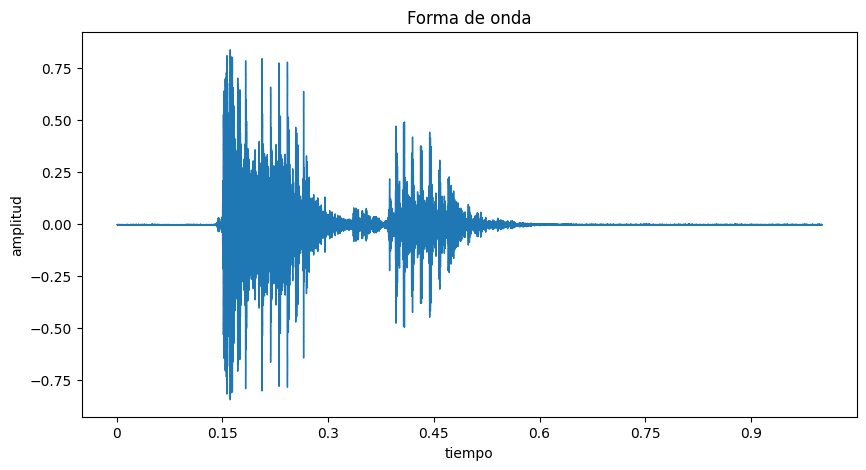

In [10]:
# graficamos la forma de onda
plt.figure(figsize=(10, 5))
librosa.display.waveshow(waveformA_numpy, sr=sample_rateA)
plt.title('Forma de onda')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

### 5. Caracteristicas

In [11]:
# tamaño de la ventana
n_fft = 1000
# tamaño del salto
hop_length = n_fft // 2

In [12]:
spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length)(waveformA)
print(spectrogram.shape, spectrogram.dtype)
spectrogram

torch.Size([1, 501, 33]) torch.float32


tensor([[[3.4630e-04, 2.9274e-05, 2.8580e-05,  ..., 1.0255e-05,
          1.8649e-05, 6.4235e-05],
         [3.4962e-04, 1.0071e-04, 2.9823e-05,  ..., 1.0178e-04,
          3.6574e-05, 1.6169e-04],
         [6.3828e-04, 1.0124e-04, 6.4328e-06,  ..., 4.3791e-04,
          1.5712e-04, 2.7300e-04],
         ...,
         [6.7521e-08, 1.2022e-07, 2.1205e-07,  ..., 9.6493e-07,
          1.1402e-06, 8.1128e-09],
         [9.5221e-08, 1.6604e-07, 1.5564e-07,  ..., 1.7882e-06,
          1.2326e-06, 2.1697e-07],
         [3.6251e-08, 8.1307e-08, 3.7848e-07,  ..., 9.6889e-07,
          1.1262e-06, 4.3512e-07]]])

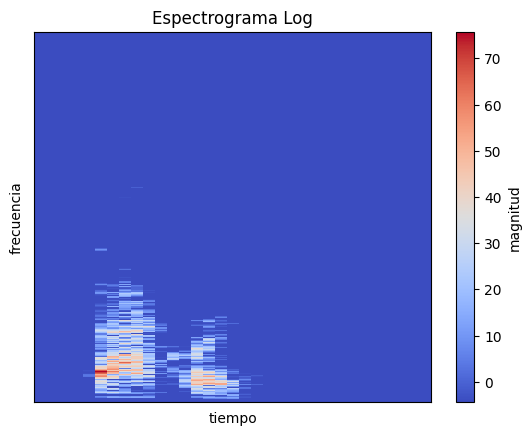

In [13]:
spectrogram_numpy = spectrogram.squeeze().numpy()
log_spectrogram = librosa.amplitude_to_db(spectrogram_numpy)

librosa.display.specshow(log_spectrogram,
                         sr=sample_rateA, hop_length=hop_length)
plt.title('Espectrograma Log')
plt.xlabel('tiempo')
plt.ylabel('frecuencia')
# Se muestra la barra de color para darnos una idea del rango de amplitudes en decibeles.
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

In [14]:
mel_spectrogram = T.MelSpectrogram(n_fft=n_fft, hop_length=hop_length)(waveformA)
print(mel_spectrogram.shape, mel_spectrogram.dtype)
mel_spectrogram

torch.Size([1, 128, 33]) torch.float32


tensor([[[2.9521e-04, 8.5035e-05, 2.5183e-05,  ..., 8.5944e-05,
          3.0883e-05, 1.3653e-04],
         [5.1000e-04, 8.7933e-05, 9.2324e-06,  ..., 3.2841e-04,
          1.1784e-04, 2.2002e-04],
         [5.3278e-04, 3.4490e-05, 1.0678e-04,  ..., 1.9573e-04,
          1.2886e-04, 2.4424e-04],
         ...,
         [6.7079e-05, 7.0378e-05, 4.9343e-05,  ..., 6.4436e-05,
          5.0066e-05, 6.8437e-05],
         [2.4897e-05, 2.3971e-05, 3.0510e-05,  ..., 4.6032e-05,
          1.7484e-05, 2.6811e-05],
         [1.6118e-05, 7.5180e-06, 5.1918e-06,  ..., 1.5016e-05,
          1.1879e-05, 2.0226e-05]]])

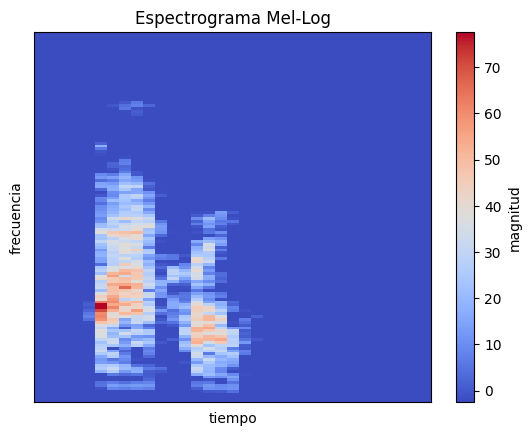

In [15]:
mel_spectrogram_numpy = mel_spectrogram.squeeze().numpy()
log_mel_spectrogram_numpy = librosa.amplitude_to_db(mel_spectrogram_numpy)

librosa.display.specshow(log_mel_spectrogram_numpy,
                         sr=sample_rateA, hop_length=hop_length)
plt.title('Espectrograma Mel-Log')
plt.xlabel('tiempo')
plt.ylabel('frecuencia')
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

In [16]:
mfccs = T.MFCC()(waveformA)
print(mfccs.shape, mfccs.dtype)
mfccs

torch.Size([1, 40, 81]) torch.float32


/home/ar/miniconda3/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


tensor([[[-5.1596e+02, -5.2068e+02, -5.1357e+02,  ..., -4.9976e+02,
          -5.0227e+02, -5.0542e+02],
         [ 1.9111e+01,  1.3181e+01,  1.9767e+01,  ...,  2.2714e+01,
           2.5238e+01,  1.9226e+01],
         [ 1.3228e+01,  9.5514e+00,  1.3591e+01,  ...,  1.8591e+01,
           1.4602e+01,  2.0137e+01],
         ...,
         [ 3.5582e+00,  3.1715e+00,  2.6139e+00,  ..., -2.3913e+00,
           2.5416e+00, -3.9608e+00],
         [ 9.7919e-01,  1.7033e+00, -2.4975e-01,  ..., -3.5801e+00,
           5.0414e-01, -4.9371e+00],
         [-5.3154e-01,  1.4709e+00,  3.0775e-01,  ...,  1.9141e-01,
           4.2464e+00, -5.0865e+00]]])

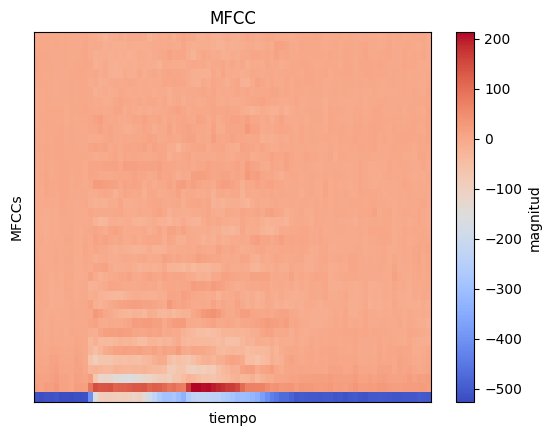

In [17]:
mfccs_numpy = mfccs.squeeze().numpy()

librosa.display.specshow(mfccs_numpy, sr=sample_rateA, hop_length=hop_length)
plt.title('MFCC')
plt.xlabel('tiempo')
plt.ylabel('MFCCs')
cbar = plt.colorbar()
cbar.set_label('magnitud', rotation=90)
plt.show()

### 6. Conjunto de Datos

In [18]:
# tamaño del lote
BATCH_SIZE = 32

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

# parámetros FFT
N_FFT = 400
HOP_LENGTH = N_FFT // 2

# SpeechCommands classes
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn',
    'left', 'marvin', 'nine', 'no', 'off',
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)

NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}
print(CLASS_IDX)


def set_seed(seed = 0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    th.manual_seed(seed)


# reproducibilidad
set_seed()

{'backward': 0, 'bed': 1, 'bird': 2, 'cat': 3, 'dog': 4, 'down': 5, 'eight': 6, 'five': 7, 'follow': 8, 'forward': 9, 'four': 10, 'go': 11, 'happy': 12, 'house': 13, 'learn': 14, 'left': 15, 'marvin': 16, 'nine': 17, 'no': 18, 'off': 19, 'on': 20, 'one': 21, 'right': 22, 'seven': 23, 'sheila': 24, 'six': 25, 'stop': 26, 'three': 27, 'tree': 28, 'two': 29, 'up': 30, 'visual': 31, 'wow': 32, 'yes': 33, 'zero': 34}


In [19]:
def label2index(label):
    return CLASS_IDX[label]

class MySpeechCommands(SPEECHCOMMANDS):
  def __init__(self, 
               root, 
               download = False, 
               subset = None,
               waveform_tsfm = None, 
               label_tsfm = None):
    super().__init__(root = root, download = download, subset = subset)
    self.waveform_tsfm = waveform_tsfm
    self.label_tsfm = label_tsfm

  def __getitem__(self, i):
    waveform, sample_rate, label, *_ = super().__getitem__(i)

    if self.waveform_tsfm:
      x = self.waveform_tsfm(waveform)
    
    if self.label_tsfm:
      y = self.label_tsfm(label)
      
    return x, y, label, sample_rate

In [20]:
class WaveformPadTruncate(nn.Module):
  def __init__(self, secs = SECS, sample_rate = SAMPLE_RATE):
    super().__init__()
    self.samples = secs * sample_rate

  def forward(self, waveform):
    samples = waveform.shape[1]

    if samples < self.samples:
      difference = self.samples - samples
      padding = th.zeros(1, difference)
      waveform = th.cat([waveform, padding], 1)

    elif samples > self.samples:
      start = random.randint(0, waveform.shape[1] - self.samples)
      # Devuelve un nuevo tensor que es una versión reducida del tensor de entrada.
      waveform = waveform.narrow(1, start, self.samples) # (dimension, start, length)

    return waveform

In [21]:
# creamos un Dataset
ds = MySpeechCommands(
  # directorio de datos
  root = DATA_DIR,
  # transformación de la forma de onda
  waveform_tsfm = WaveformPadTruncate(),
  # transformación de etiqueta
  label_tsfm = label2index,
)

# creamos un DataLoader
dl = DataLoader(
  # conjunto
  ds,
  # tamaño del lote
  batch_size = BATCH_SIZE,
  # desordenar
  shuffle = True)


In [22]:
# desplegamos un lote de ejemplos
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
print(f"Total de audios: {sum(counter.values())}")

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64
Total de audios: 105829


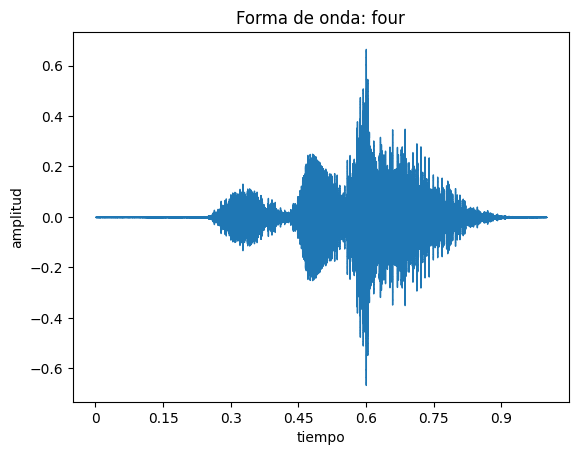

In [23]:
# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = labels[0]

# grafiquemos forma de onda
librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

### 7. RNN

In [24]:
class WaveformToMelSpectrogram(nn.Module):
    def __init__(self, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=64):
        super().__init__()
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.amplitude_to_db = T.AmplitudeToDB()
    
    def forward(self, waveform):
        # waveform: [1, samples] for single sample OR [batch, 1, samples] for batch
        mel_spec = self.mel_spectrogram(waveform)  
        # mel_spec: [1, n_mels, frames] OR [batch, 1, n_mels, frames]
        
        mel_spec_db = self.amplitude_to_db(mel_spec)
        
        # Remove ALL dimensions of size 1
        mel_spec_db = mel_spec_db.squeeze()
        
        # If we squeezed too much (single sample case), ensure we have 2D
        if mel_spec_db.ndim == 1:
            mel_spec_db = mel_spec_db.unsqueeze(0)
        
        # Now we should have [n_mels, frames] for single sample
        # Transpose to [frames, n_mels]
        mel_spec_db = mel_spec_db.transpose(-2, -1)
        
        return mel_spec_db

In [25]:
# Arquitectura del Modelo RNN

class SpeechCommandRNN(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, num_layers=2, 
                 num_classes=NUM_CLASSES, dropout=0.3, bidirectional=True):
        super().__init__()
        
        # LSTM layers
        # input: [batch, frames, features] donde features son las frecuencias
        self.lstm = nn.LSTM(
            input_size=input_size,      # número de características (frecuencias mel)
            hidden_size=hidden_size,    # tamaño del estado oculto
            num_layers=num_layers,      # número de capas LSTM apiladas
            batch_first=True,           # input es [batch, seq, features]
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional # LSTM bidireccional
        )
        
        # Factor para bidireccional
        self.d = 2 if bidirectional else 1
        
        # Capa de atención simple (opcional pero mejora resultados)
        self.attention = nn.Linear(hidden_size * self.d, 1)
        
        # Capas fully connected
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * self.d, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # x: [batch, frames, n_mels]
        # frames = tiempo (secuencia)
        # n_mels = características (frecuencias)
        
        # LSTM procesa la secuencia temporal
        lstm_out, (h_n, c_n) = self.lstm(x)  # [batch, frames, hidden*d]
        
        # Atención: dar más peso a frames importantes
        attn_weights = th.softmax(self.attention(lstm_out), dim=1)  # [batch, frames, 1]
        attended = th.sum(attn_weights * lstm_out, dim=1)  # [batch, hidden*d]
        
        # Clasificación
        output = self.fc(attended)  # [batch, num_classes]
        
        return output
    
    def __str__(self):
        return f"SpeechCommandRNN(lstm_layers={self.lstm.num_layers}, " \
               f"hidden={self.lstm.hidden_size}, bidirectional={self.lstm.bidirectional})"

In [26]:
# Transformación combinada
rnn_transform = nn.Sequential(
    WaveformPadTruncate(),
    WaveformToMelSpectrogram(n_mels=64)
)

# Crear datasets de entrenamiento y validación
train_ds = MySpeechCommands(
    root=DATA_DIR,
    subset='training',
    waveform_tsfm=rnn_transform,
    label_tsfm=label2index
)

val_ds = MySpeechCommands(
    root=DATA_DIR,
    subset='validation',
    waveform_tsfm=rnn_transform,
    label_tsfm=label2index
)

test_ds = MySpeechCommands(
    root=DATA_DIR,
    subset='testing',
    waveform_tsfm=rnn_transform,
    label_tsfm=label2index
)

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

x_check, y_check, _, _ = next(iter(train_dl))
print(f"\n✓ Input shape: {x_check.shape} (should be [batch, frames, n_mels])")

Training samples: 84843
Validation samples: 9981
Test samples: 11005

✓ Input shape: torch.Size([32, 81, 64]) (should be [batch, frames, n_mels])


Input shape: torch.Size([32, 81, 64])
  - Batch size: 32
  - Frames (tiempo): 81
  - Features (frecuencias mel): 64

Output shape: torch.Size([32])


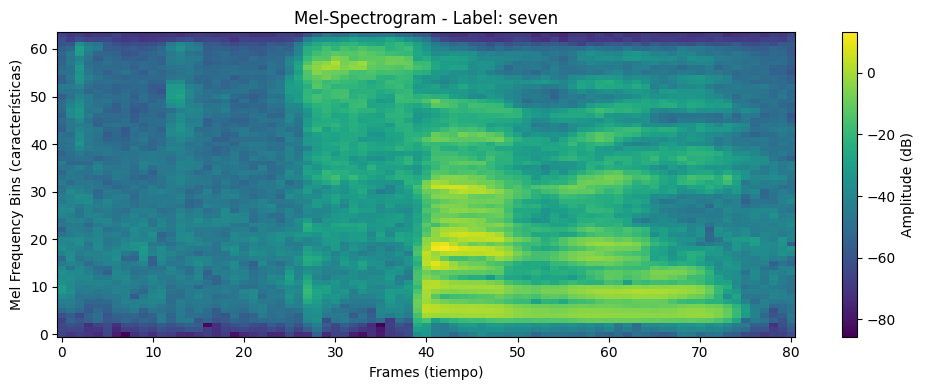

In [27]:
# Verificar forma de los datos

# Obtener un batch de ejemplo
x_batch, y_batch, labels, sr = next(iter(train_dl))

print(f"Input shape: {x_batch.shape}")  # [batch, frames, n_mels]
print(f"  - Batch size: {x_batch.shape[0]}")
print(f"  - Frames (tiempo): {x_batch.shape[1]}")
print(f"  - Features (frecuencias mel): {x_batch.shape[2]}")
print(f"\nOutput shape: {y_batch.shape}")  # [batch]

# Visualizar un espectrograma
plt.figure(figsize=(10, 4))
plt.imshow(x_batch[0].numpy().T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude (dB)')
plt.xlabel('Frames (tiempo)')
plt.ylabel('Mel Frequency Bins (características)')
plt.title(f'Mel-Spectrogram - Label: {labels[0]}')
plt.tight_layout()
plt.show()

In [28]:
# Función de Entrenamiento

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for x, y, _, _ in tqdm(dataloader, desc='Training', leave=False):
        x, y = x.to(device), y.to(device)
        
        # Forward
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Métricas
        running_loss += loss.item() * x.size(0)
        _, predicted = th.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with th.no_grad():
        for x, y, _, _ in tqdm(dataloader, desc='Validation', leave=False):
            x, y = x.to(device), y.to(device)
            
            outputs = model(x)
            loss = criterion(outputs, y)
            
            running_loss += loss.item() * x.size(0)
            _, predicted = th.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [29]:
# Entrenar el Modelo RNN

# Configuración
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Crear modelo
model_rnn = SpeechCommandRNN(
    input_size=64,      # número de mels (características)
    hidden_size=128,    # tamaño del estado oculto
    num_layers=2,       # capas LSTM
    num_classes=NUM_CLASSES,
    dropout=0.3,
    bidirectional=True
).to(device)

print(model_rnn)
print(f"\nParámetros totales: {sum(p.numel() for p in model_rnn.parameters()):,}")

# Criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_rnn.parameters(), lr=0.001)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                      factor=0.5, patience=3)

# Entrenar
num_epochs = 10
history_rnn = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model_rnn, train_dl, criterion, optimizer, device)
    history_rnn['train_loss'].append(train_loss)
    history_rnn['train_acc'].append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model_rnn, val_dl, criterion, device)
    history_rnn['val_loss'].append(val_loss)
    history_rnn['val_acc'].append(val_acc)
    
    # Scheduler
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("\n¡Entrenamiento completado!")

Usando dispositivo: cuda
SpeechCommandRNN(lstm_layers=2, hidden=128, bidirectional=True)

Parámetros totales: 631,588

Epoch 1/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 1.0701 | Train Acc: 0.6853
Val Loss: 0.5087 | Val Acc: 0.8423

Epoch 2/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.5523 | Train Acc: 0.8360
Val Loss: 0.4218 | Val Acc: 0.8729

Epoch 3/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.4565 | Train Acc: 0.8635
Val Loss: 0.3538 | Val Acc: 0.8923

Epoch 4/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.4019 | Train Acc: 0.8800
Val Loss: 0.2987 | Val Acc: 0.9102

Epoch 5/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.3705 | Train Acc: 0.8889
Val Loss: 0.3027 | Val Acc: 0.9074

Epoch 6/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.3441 | Train Acc: 0.8956
Val Loss: 0.2803 | Val Acc: 0.9159

Epoch 7/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.3284 | Train Acc: 0.9008
Val Loss: 0.2693 | Val Acc: 0.9178

Epoch 8/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.3090 | Train Acc: 0.9069
Val Loss: 0.2665 | Val Acc: 0.9207

Epoch 9/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.2971 | Train Acc: 0.9102
Val Loss: 0.2651 | Val Acc: 0.9240

Epoch 10/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.2888 | Train Acc: 0.9126
Val Loss: 0.2701 | Val Acc: 0.9213

¡Entrenamiento completado!


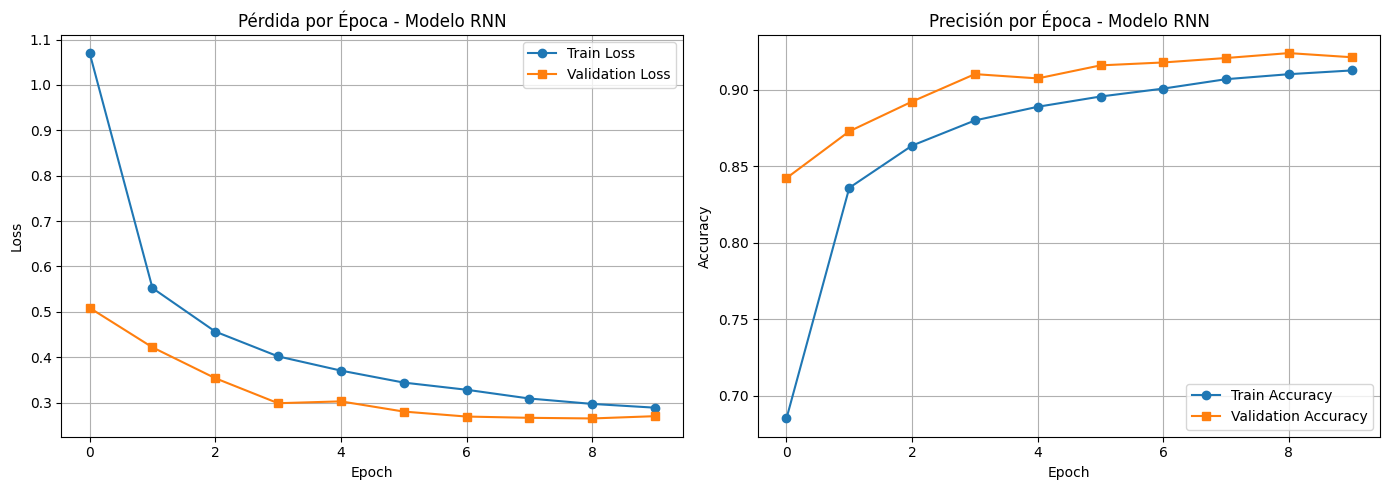

In [30]:
# Visualizar Resultados del RNN

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history_rnn['train_loss'], label='Train Loss', marker='o')
ax1.plot(history_rnn['val_loss'], label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Pérdida por Época - Modelo RNN')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history_rnn['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history_rnn['val_acc'], label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Precisión por Época - Modelo RNN')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 8. CNN 1D

In [31]:
class WaveformToMelSpectrogram1D(nn.Module):
    """
    Transforma waveform a Mel-Spectrogram para CNN 1D
    Output: [batch, n_mels, frames] donde n_mels son canales y frames es tiempo
    """
    def __init__(self, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=64):
        super().__init__()
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.amplitude_to_db = T.AmplitudeToDB()
    
    def forward(self, waveform):
        # waveform: [batch, 1, samples]
        mel_spec = self.mel_spectrogram(waveform)  # [batch, 1, n_mels, frames]
        mel_spec_db = self.amplitude_to_db(mel_spec)  # [batch, 1, n_mels, frames]
        
        # Squeeze the channel dimension and ensure correct shape
        mel_spec_db = mel_spec_db.squeeze()  # [batch, n_mels, frames]
        
        return mel_spec_db

In [32]:
# Arquitectura del Modelo CNN 1D

class SpeechCommandCNN1D(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, input_channels=64, dropout=0.3):
        super().__init__()
        
        # En CNN 1D:
        # - input_channels = n_mels (64 frecuencias mel)
        # - kernel convoluciona a lo largo del tiempo (frames)
        
        self.conv_blocks = nn.Sequential(
            # Block 1: 64 channels -> 128 channels
            nn.Conv1d(in_channels=input_channels, out_channels=128, 
                     kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # reduce tiempo por 2
            nn.Dropout(dropout),
            
            # Block 2: 128 -> 256 channels
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # reduce tiempo por 2
            nn.Dropout(dropout),
            
            # Block 3: 256 -> 512 channels
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # reduce tiempo por 2
            nn.Dropout(dropout),
            
            # Block 4: 512 -> 512 channels
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # Global Average Pooling -> [batch, 512, 1]
        )
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Flatten(),  # [batch, 512]
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # x: [batch, n_mels, frames] = [batch, 64, 81]
        # donde 64 son los canales (frecuencias) y 81 es la dimensión temporal
        
        # Convoluciones 1D a lo largo del tiempo
        x = self.conv_blocks(x)  # [batch, 512, 1]
        
        # Clasificación
        x = self.classifier(x)  # [batch, num_classes]
        
        return x
    
    def __str__(self):
        return "SpeechCommandCNN1D(4 conv blocks, channels: 64->128->256->512->512)"

In [ ]:
# Transformación combinada para CNN 1D
cnn1d_transform = nn.Sequential(
    WaveformPadTruncate(),
    WaveformToMelSpectrogram1D(n_mels=64)
)

# Crear datasets de entrenamiento y validación para CNN 1D
train_ds_cnn1d = MySpeechCommands(
    root=DATA_DIR,
    subset='training',
    waveform_tsfm=cnn1d_transform,
    label_tsfm=label2index
)

val_ds_cnn1d = MySpeechCommands(
    root=DATA_DIR,
    subset='validation',
    waveform_tsfm=cnn1d_transform,
    label_tsfm=label2index
)

test_ds_cnn1d = MySpeechCommands(
    root=DATA_DIR,
    subset='testing',
    waveform_tsfm=cnn1d_transform,
    label_tsfm=label2index
)

# DataLoaders
train_dl_cnn1d = DataLoader(train_ds_cnn1d, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dl_cnn1d = DataLoader(val_ds_cnn1d, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dl_cnn1d = DataLoader(test_ds_cnn1d, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_ds_cnn1d)}")
print(f"Validation samples: {len(val_ds_cnn1d)}")
print(f"Test samples: {len(test_ds_cnn1d)}")

# Verificar forma de los datos
x_check, y_check, _, _ = next(iter(train_dl_cnn1d))
print(f"\n✓ Input shape: {x_check.shape} ([batch, n_mels, frames])")
print(f"  - Batch size: {x_check.shape[0]}")
print(f"  - Channels (frecuencias mel): {x_check.shape[1]}")
print(f"  - Sequence length (frames/tiempo): {x_check.shape[2]}")

Training samples: 84843
Validation samples: 9981
Test samples: 11005

✓ Input shape: torch.Size([32, 64, 81]) (should be [batch, n_mels, frames])
  - Batch size: 32
  - Channels (frecuencias mel): 64
  - Sequence length (frames/tiempo): 81


Input shape: torch.Size([32, 64, 81])
  - Batch size: 32
  - Channels (frecuencias mel): 64
  - Sequence length (tiempo): 81

Output shape: torch.Size([32])


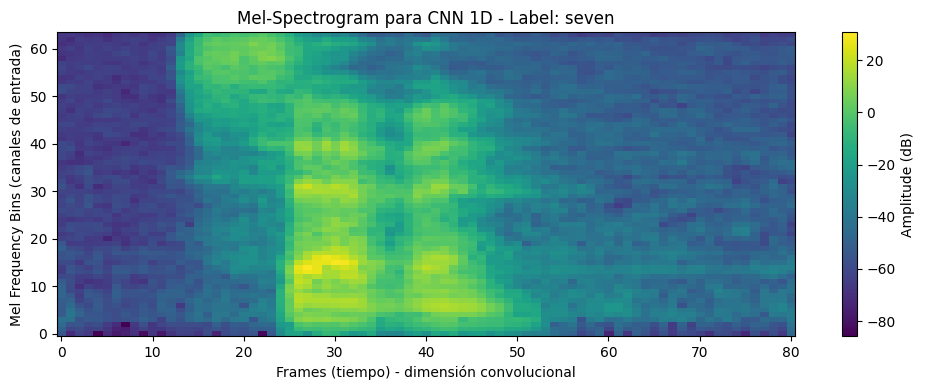

In [34]:
# Visualizar forma de entrada para CNN 1D

x_batch, y_batch, labels, sr = next(iter(train_dl_cnn1d))

print(f"Input shape: {x_batch.shape}")  # [batch, n_mels, frames]
print(f"  - Batch size: {x_batch.shape[0]}")
print(f"  - Channels (frecuencias mel): {x_batch.shape[1]}")
print(f"  - Sequence length (tiempo): {x_batch.shape[2]}")
print(f"\nOutput shape: {y_batch.shape}")  # [batch]

# Visualizar un espectrograma
plt.figure(figsize=(10, 4))
plt.imshow(x_batch[0].numpy().squeeze(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude (dB)')
plt.xlabel('Frames (tiempo) - dimensión convolucional')
plt.ylabel('Mel Frequency Bins (canales de entrada)')
plt.title(f'Mel-Spectrogram para CNN 1D - Label: {labels[0]}')
plt.tight_layout()
plt.show()

In [35]:
# Entrenar el Modelo CNN 1D

# Configuración
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Crear modelo
model_cnn1d = SpeechCommandCNN1D(
    num_classes=NUM_CLASSES,
    input_channels=64,  # número de mels (canales de entrada)
    dropout=0.3
).to(device)

print(model_cnn1d)
print(f"\nParámetros totales: {sum(p.numel() for p in model_cnn1d.parameters()):,}")

# Criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_cnn1d.parameters(), lr=0.001)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                      factor=0.5, patience=3)

# Entrenar
num_epochs = 10
history_cnn1d = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model_cnn1d, train_dl_cnn1d, criterion, optimizer, device)
    history_cnn1d['train_loss'].append(train_loss)
    history_cnn1d['train_acc'].append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model_cnn1d, val_dl_cnn1d, criterion, device)
    history_cnn1d['val_loss'].append(val_loss)
    history_cnn1d['val_acc'].append(val_acc)
    
    # Scheduler
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("\n¡Entrenamiento completado!")

Usando dispositivo: cuda
SpeechCommandCNN1D(4 conv blocks, channels: 64->128->256->512->512)

Parámetros totales: 1,447,075

Epoch 1/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 1.1509 | Train Acc: 0.6584
Val Loss: 0.4423 | Val Acc: 0.8689

Epoch 2/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.5802 | Train Acc: 0.8267
Val Loss: 0.3229 | Val Acc: 0.9043

Epoch 3/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.4575 | Train Acc: 0.8632
Val Loss: 0.2605 | Val Acc: 0.9208

Epoch 4/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.3973 | Train Acc: 0.8806
Val Loss: 0.2239 | Val Acc: 0.9345

Epoch 5/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.3537 | Train Acc: 0.8938
Val Loss: 0.2174 | Val Acc: 0.9348

Epoch 6/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.3242 | Train Acc: 0.9027
Val Loss: 0.1893 | Val Acc: 0.9435

Epoch 7/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.3019 | Train Acc: 0.9083
Val Loss: 0.2025 | Val Acc: 0.9405

Epoch 8/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.2801 | Train Acc: 0.9159
Val Loss: 0.1801 | Val Acc: 0.9499

Epoch 9/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.2684 | Train Acc: 0.9185
Val Loss: 0.1842 | Val Acc: 0.9436

Epoch 10/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.2512 | Train Acc: 0.9222
Val Loss: 0.1705 | Val Acc: 0.9500

¡Entrenamiento completado!


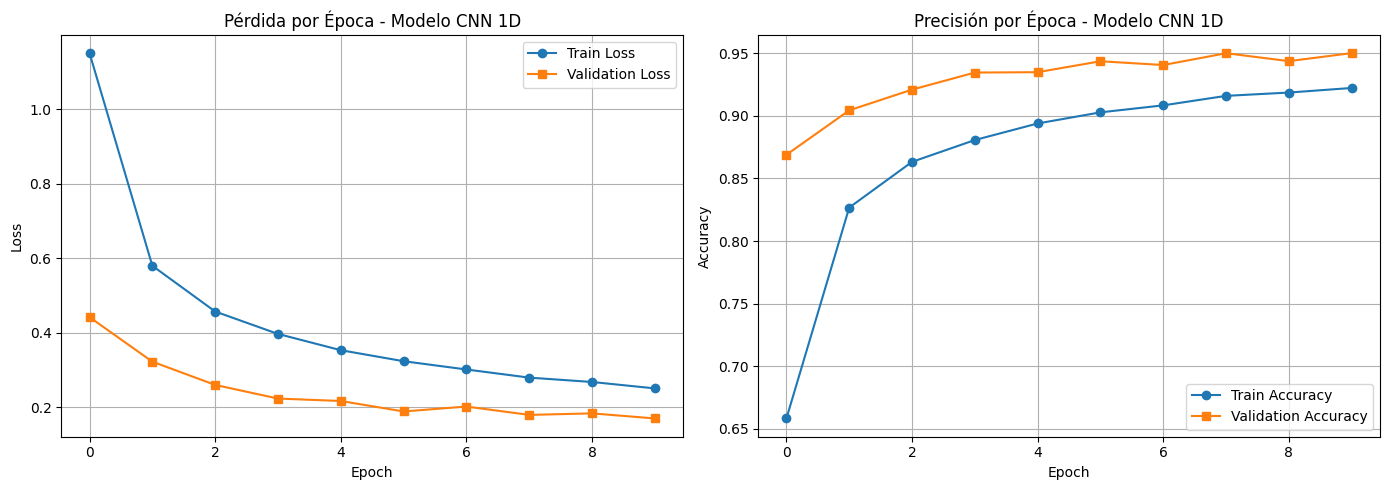

In [36]:
# Visualizar Resultados del CNN 1D

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history_cnn1d['train_loss'], label='Train Loss', marker='o')
ax1.plot(history_cnn1d['val_loss'], label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Pérdida por Época - Modelo CNN 1D')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history_cnn1d['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history_cnn1d['val_acc'], label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Precisión por Época - Modelo CNN 1D')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 9. CNN 2D

In [37]:
class WaveformToMelSpectrogram2D(nn.Module):
    """
    Transforma waveform a Mel-Spectrogram para CNN 2D
    Output: [batch, 1, n_mels, frames] donde tratamos el espectrograma como una imagen 2D
    """
    def __init__(self, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=64):
        super().__init__()
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )
        self.amplitude_to_db = T.AmplitudeToDB()
    
    def forward(self, waveform):
        # waveform: [batch, 1, samples]
        mel_spec = self.mel_spectrogram(waveform)  # [batch, 1, n_mels, frames]
        mel_spec_db = self.amplitude_to_db(mel_spec)  # [batch, 1, n_mels, frames]
        
        # Mantener el canal como 1 (imagen en escala de grises)
        return mel_spec_db

In [38]:
# Arquitectura del Modelo CNN 2D

class SpeechCommandCNN2D(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, dropout=0.3):
        super().__init__()
        
        # En CNN 2D:
        # - Input: [batch, 1, n_mels, frames] = [batch, 1, 64, 81]
        # - Tratamos el espectrograma como una imagen 2D (como grayscale)
        # - Los kernels convoluciona en ambas dimensiones: frecuencia y tiempo
        
        self.conv_blocks = nn.Sequential(
            # Block 1: 1 -> 32 channels
            nn.Conv2d(in_channels=1, out_channels=32, 
                     kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce por 2 en ambas dimensiones
            nn.Dropout(dropout),
            
            # Block 2: 32 -> 64 channels
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce por 2 en ambas dimensiones
            nn.Dropout(dropout),
            
            # Block 3: 64 -> 128 channels
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # reduce por 2 en ambas dimensiones
            nn.Dropout(dropout),
            
            # Block 4: 128 -> 256 channels
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling -> [batch, 256, 1, 1]
        )
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.Flatten(),  # [batch, 256]
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # x: [batch, 1, n_mels, frames] = [batch, 1, 64, 81]
        # Similar a una imagen en escala de grises
        
        # Convoluciones 2D sobre frecuencia y tiempo
        x = self.conv_blocks(x)  # [batch, 256, 1, 1]
        
        # Clasificación
        x = self.classifier(x)  # [batch, num_classes]
        
        return x
    
    def __str__(self):
        return "SpeechCommandCNN2D(4 conv blocks, channels: 1->32->64->128->256)"

In [39]:
# Transformación combinada para CNN 2D
cnn2d_transform = nn.Sequential(
    WaveformPadTruncate(),
    WaveformToMelSpectrogram2D(n_mels=64)
)

# Crear datasets de entrenamiento y validación para CNN 2D
train_ds_cnn2d = MySpeechCommands(
    root=DATA_DIR,
    subset='training',
    waveform_tsfm=cnn2d_transform,
    label_tsfm=label2index
)

val_ds_cnn2d = MySpeechCommands(
    root=DATA_DIR,
    subset='validation',
    waveform_tsfm=cnn2d_transform,
    label_tsfm=label2index
)

test_ds_cnn2d = MySpeechCommands(
    root=DATA_DIR,
    subset='testing',
    waveform_tsfm=cnn2d_transform,
    label_tsfm=label2index
)

# DataLoaders
train_dl_cnn2d = DataLoader(train_ds_cnn2d, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dl_cnn2d = DataLoader(val_ds_cnn2d, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dl_cnn2d = DataLoader(test_ds_cnn2d, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_ds_cnn2d)}")
print(f"Validation samples: {len(val_ds_cnn2d)}")
print(f"Test samples: {len(test_ds_cnn2d)}")

# Verificar forma de los datos
x_check, y_check, _, _ = next(iter(train_dl_cnn2d))
print(f"\n✓ Input shape: {x_check.shape} (should be [batch, 1, n_mels, frames])")
print(f"  - Batch size: {x_check.shape[0]}")
print(f"  - Channels: {x_check.shape[1]} (como imagen en escala de grises)")
print(f"  - Height (frecuencias mel): {x_check.shape[2]}")
print(f"  - Width (frames/tiempo): {x_check.shape[3]}")

Training samples: 84843
Validation samples: 9981
Test samples: 11005

✓ Input shape: torch.Size([32, 1, 64, 81]) (should be [batch, 1, n_mels, frames])
  - Batch size: 32
  - Channels: 1 (como imagen en escala de grises)
  - Height (frecuencias mel): 64
  - Width (frames/tiempo): 81


Input shape: torch.Size([32, 1, 64, 81])
  - Batch size: 32
  - Channels: 1 (canal único como imagen grayscale)
  - Height (frecuencias mel): 64
  - Width (frames/tiempo): 81

Output shape: torch.Size([32])


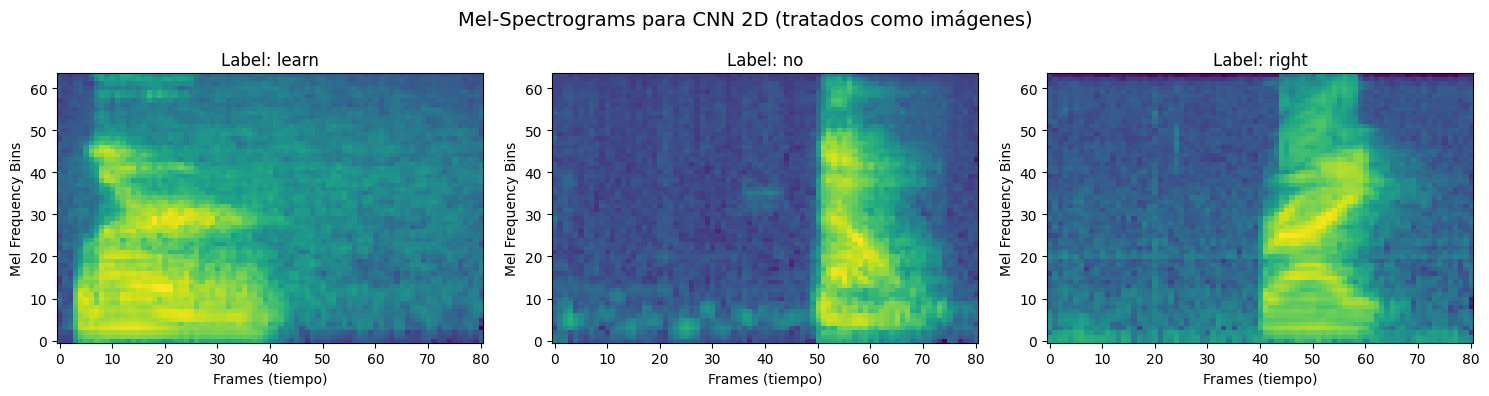

In [40]:
# Visualizar forma de entrada para CNN 2D

x_batch, y_batch, labels, sr = next(iter(train_dl_cnn2d))

print(f"Input shape: {x_batch.shape}")  # [batch, 1, n_mels, frames]
print(f"  - Batch size: {x_batch.shape[0]}")
print(f"  - Channels: {x_batch.shape[1]} (canal único como imagen grayscale)")
print(f"  - Height (frecuencias mel): {x_batch.shape[2]}")
print(f"  - Width (frames/tiempo): {x_batch.shape[3]}")
print(f"\nOutput shape: {y_batch.shape}")  # [batch]

# Visualizar un espectrograma como imagen 2D
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    axes[i].imshow(x_batch[i].squeeze().numpy(), aspect='auto', origin='lower', cmap='viridis')
    axes[i].set_xlabel('Frames (tiempo)')
    axes[i].set_ylabel('Mel Frequency Bins')
    axes[i].set_title(f'Label: {labels[i]}')

fig.suptitle('Mel-Spectrograms para CNN 2D (tratados como imágenes)', fontsize=14)
plt.tight_layout()
plt.show()

In [41]:
# Entrenar el Modelo CNN 2D

# Configuración
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Crear modelo
model_cnn2d = SpeechCommandCNN2D(
    num_classes=NUM_CLASSES,
    dropout=0.3
).to(device)

print(model_cnn2d)
print(f"\nParámetros totales: {sum(p.numel() for p in model_cnn2d.parameters()):,}")

# Criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_cnn2d.parameters(), lr=0.001)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                      factor=0.5, patience=3)

# Entrenar
num_epochs = 10
history_cnn2d = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model_cnn2d, train_dl_cnn2d, criterion, optimizer, device)
    history_cnn2d['train_loss'].append(train_loss)
    history_cnn2d['train_acc'].append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model_cnn2d, val_dl_cnn2d, criterion, device)
    history_cnn2d['val_loss'].append(val_loss)
    history_cnn2d['val_acc'].append(val_acc)
    
    # Scheduler
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("\n¡Entrenamiento completado!")

Usando dispositivo: cuda
SpeechCommandCNN2D(4 conv blocks, channels: 1->32->64->128->256)

Parámetros totales: 426,211

Epoch 1/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 2.2005 | Train Acc: 0.3537
Val Loss: 1.2377 | Val Acc: 0.6308

Epoch 2/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 1.1929 | Train Acc: 0.6404
Val Loss: 0.6835 | Val Acc: 0.8008

Epoch 3/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.8534 | Train Acc: 0.7421
Val Loss: 0.4517 | Val Acc: 0.8796

Epoch 4/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.7094 | Train Acc: 0.7852
Val Loss: 0.3811 | Val Acc: 0.8927

Epoch 5/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.6131 | Train Acc: 0.8156
Val Loss: 0.3173 | Val Acc: 0.9108

Epoch 6/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.5562 | Train Acc: 0.8323
Val Loss: 0.2836 | Val Acc: 0.9197

Epoch 7/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.5086 | Train Acc: 0.8483
Val Loss: 0.2631 | Val Acc: 0.9249

Epoch 8/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.4738 | Train Acc: 0.8580
Val Loss: 0.2566 | Val Acc: 0.9284

Epoch 9/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.4458 | Train Acc: 0.8673
Val Loss: 0.2385 | Val Acc: 0.9325

Epoch 10/10


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

Validation:   0%|          | 0/312 [00:00<?, ?it/s]

Train Loss: 0.4195 | Train Acc: 0.8741
Val Loss: 0.2152 | Val Acc: 0.9407

¡Entrenamiento completado!


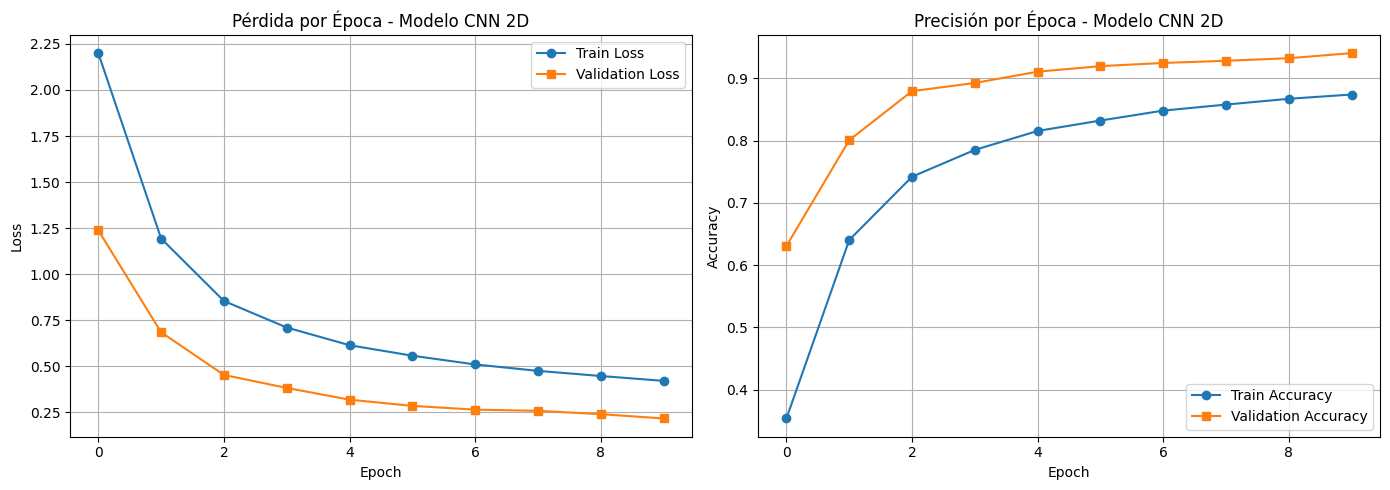

In [42]:
# Visualizar Resultados del CNN 2D

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history_cnn2d['train_loss'], label='Train Loss', marker='o')
ax1.plot(history_cnn2d['val_loss'], label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Pérdida por Época - Modelo CNN 2D')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history_cnn2d['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history_cnn2d['val_acc'], label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Precisión por Época - Modelo CNN 2D')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 10. Comparando los 3 modelos

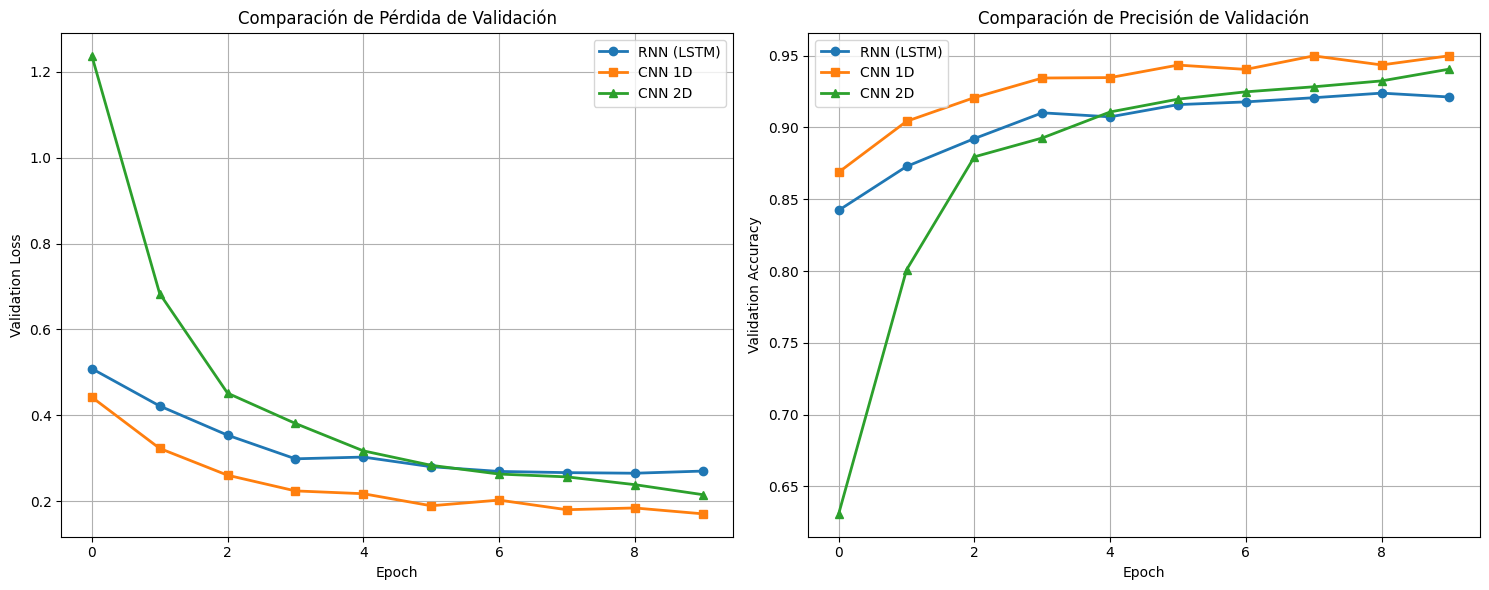


RESUMEN DE RESULTADOS

RNN (LSTM):
  - Mejor Val Loss: 0.2651
  - Mejor Val Acc: 0.9240
  - Parámetros: 631,588

CNN 1D:
  - Mejor Val Loss: 0.1705
  - Mejor Val Acc: 0.9500
  - Parámetros: 1,447,075

CNN 2D:
  - Mejor Val Loss: 0.2152
  - Mejor Val Acc: 0.9407
  - Parámetros: 426,211


In [43]:
# Comparación de los tres modelos

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Comparar pérdidas de validación
ax1.plot(history_rnn['val_loss'], label='RNN (LSTM)', marker='o', linewidth=2)
ax1.plot(history_cnn1d['val_loss'], label='CNN 1D', marker='s', linewidth=2)
ax1.plot(history_cnn2d['val_loss'], label='CNN 2D', marker='^', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.set_title('Comparación de Pérdida de Validación')
ax1.legend()
ax1.grid(True)

# Comparar precisiones de validación
ax2.plot(history_rnn['val_acc'], label='RNN (LSTM)', marker='o', linewidth=2)
ax2.plot(history_cnn1d['val_acc'], label='CNN 1D', marker='s', linewidth=2)
ax2.plot(history_cnn2d['val_acc'], label='CNN 2D', marker='^', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Comparación de Precisión de Validación')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Imprimir resumen
print("\n" + "="*60)
print("RESUMEN DE RESULTADOS")
print("="*60)
print(f"\nRNN (LSTM):")
print(f"  - Mejor Val Loss: {min(history_rnn['val_loss']):.4f}")
print(f"  - Mejor Val Acc: {max(history_rnn['val_acc']):.4f}")
print(f"  - Parámetros: {sum(p.numel() for p in model_rnn.parameters()):,}")

print(f"\nCNN 1D:")
print(f"  - Mejor Val Loss: {min(history_cnn1d['val_loss']):.4f}")
print(f"  - Mejor Val Acc: {max(history_cnn1d['val_acc']):.4f}")
print(f"  - Parámetros: {sum(p.numel() for p in model_cnn1d.parameters()):,}")

print(f"\nCNN 2D:")
print(f"  - Mejor Val Loss: {min(history_cnn2d['val_loss']):.4f}")
print(f"  - Mejor Val Acc: {max(history_cnn2d['val_acc']):.4f}")
print(f"  - Parámetros: {sum(p.numel() for p in model_cnn2d.parameters()):,}")
print("="*60)

### Discusión 

**Los 3 modelos**
- Las curvas de entrenamiento y validación se mantuvieron cercanas
- No se observó overfitting significativo en ninguno de los tres modelos
- **CNN 1D y RNN**: Convergieron rápidamente en las primeras 5 épocas
- **CNN 2D**: Mostró convergencia más gradual, sugiriendo que podría beneficiarse de más épocas de entrenamiento

Todos los modelos utilizaron **espectrogramas Mel-Log** (64 bandas Mel):

- Comprime información espectral de manera perceptualmente relevante
- Reduce dimensionalidad respecto al espectrograma completo
- La escala Mel se alinea con la percepción humana del pitch

**Alternativas consideradas:**
- MFCCs: Más compactos (40 coeficientes) pero podrían perder información útil
- Espectrograma estándar: Mayor resolución pero más parámetros necesarios


**En conclusión**
- **CNN 1D es la mejor opción** cuando se prioriza accuracy, logrando 95% en validación.
- **CNN 2D ofrece el mejor compromiso** entre rendimiento (94.07%) y eficiencia paramétrica (426K parámetros).
